# Use This if you are using Kaggle Notebook

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
# download the dataset to your folder or use it on kaggle notebook directly

train_file = np.load('../cse-251-b-2025/train.npz')
# train_file = np.load('/kaggle/input/cse-251-b-2025/train.npz')

train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('../cse-251-b-2025/test_input.npz')
# test_file = np.load('/kaggle/input/cse-251-b-2025/test_input.npz')

test_data = test_file['data']
print("test_data's shape", test_data.shape)


train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


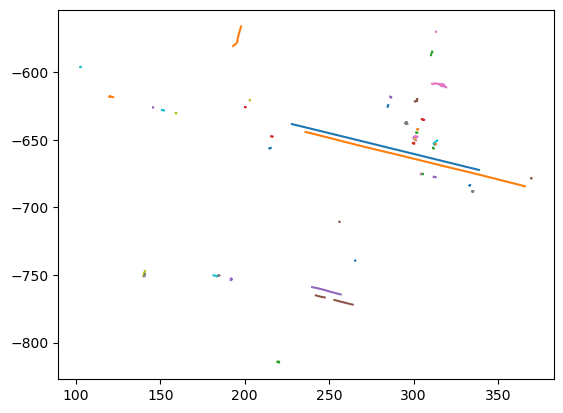

In [18]:
# plot one
import matplotlib.pyplot as plt

data_matrix = train_data[0]

for i in range(data_matrix.shape[0]):
    xs = data_matrix[i, :, 0]
    ys = data_matrix[i, :, 1]
    # trim all zeros
    xs = xs[xs != 0]
    ys = ys[ys != 0]
    # plot each line going from transparent to full
    plt.plot(xs, ys)

plt.show()

In [8]:
 # say you have a model trained. we write a dummy model just to show useage

def dummy_model(input_data):
    return np.ones((2100, 1, 60, 2))


output = dummy_model(test_data)
output.shape

(2100, 1, 60, 2)

In [9]:
# reshape to fit desired format: (2100, 1, 60, 2) -> (12600, 2)
dummy_output = output.reshape(-1, 2)
output_df = pd.DataFrame(dummy_output, columns=['x', 'y'])

# adding a necessary step to match index of your prediction to that of the solution key

output_df.index.name = 'index'

output_df.to_csv('dummy_submission.csv')

In [10]:
# Split x and y for train data.

train_x, train_y = train_data[..., :50, :], train_data[:, 0, 50:, :2]

# get the average velocity of the prediction agent
velocity_diff = train_x[...,1:, :2] - train_x[...,:-1, :2]
print(velocity_diff.shape)

constant_vel = np.mean(velocity_diff[:,0, :, :], axis=-2)
print(constant_vel.shape)

(10000, 50, 49, 2)
(10000, 2)


In [11]:
# create pred_y

pred_y = np.zeros((10000, 60, 2))
starting_point = train_x[:, 0, -1, :2] # shape (10000, 2)

for t in range(60):
    pred_y[:,t,:] = starting_point + (t+1) * constant_vel

In [12]:
# calculate train loss

mse = ((train_y - pred_y)**2).mean()
print(mse)

54.18623384395051


In [13]:
# prepare submission


# get the average velocity of the prediction agent
velocity_diff = test_data[...,1:, :2] - test_data[...,:-1, :2]
print(velocity_diff.shape)

constant_vel = np.mean(velocity_diff[:,0, :, :], axis=-2)
print(constant_vel.shape)

(2100, 50, 49, 2)
(2100, 2)


In [14]:
# create pred_y for test set

pred_y = np.zeros((2100, 60, 2))
starting_point = test_data[:, 0, -1, :2]

for t in range(60):
    pred_y[:,t,:] = starting_point + (t+1) * constant_vel

In [15]:
# reshape to fit desired format: (2100, 60, 2) -> (12600, 2)
pred_output = pred_y.reshape(-1, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])

# adding a necessary step to match index of your prediction to that of the solution key

output_df.index.name = 'index'

output_df.to_csv('constant_vel_submission.csv')

In [16]:
# Split x and y for train data.

train_x, train_y = train_data[..., :50, :], train_data[:, 0, 50:, :2]

print(train_x.shape, train_y.shape)

(10000, 50, 50, 6) (10000, 60, 2)


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()

        # Define the layers
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(256, output_features)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.mlp(x)
        return x


In [ ]:
# Calculate the total number of features after flattening
input_features = 50 * 50 * 6  # = 5000
output_features = 60 * 2


# Create the model
model = MLP(input_features, output_features)

# Define loss function and optimizer
criterion = nn.MSELoss()  # For regression task

optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:

# Example of how to prepare data and train the model

def train_model(model, x_train, y_train, batch_size=64, epochs=10):
    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.FloatTensor(x_train).reshape((-1, input_features))
    y_train_tensor = torch.FloatTensor(y_train).reshape((-1, output_features))

    # Create dataset and dataloader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    for epoch in range(epochs):
        running_loss = 0.0

        for batch_X, batch_y in tqdm(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_X)

            # Calculate loss
            loss = criterion(outputs, batch_y)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print epoch statistics
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}')
    return model


In [ ]:
model = train_model(model, train_x, train_y)

In [ ]:

def predict(X_test):
    """Make predictions with the trained model"""
    model.eval()  # Set to evaluation mode
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test).reshape((-1, input_features))
        predictions = model(X_test_tensor).reshape((-1, 60, 2))
    return predictions.numpy()

# Save model
def save_model(path="mlp_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# Load model
def load_model(path="mlp_model.pth"):
    loaded_model = MLP()
    loaded_model.load_state_dict(torch.load(path))
    loaded_model.eval()
    return loaded_model

In [ ]:

pred_y = predict(test_data)

pred_output = pred_y.reshape(-1, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])

# adding a necessary step to match index of your prediction to that of the solution key

output_df.index.name = 'index'

output_df.to_csv('mlp_baseline.csv')

 # Now you can submit to the leaderboard!